In [52]:
import torch
import torchvision
import tqdm.notebook as tqdm
import pytorch_eff_vis_pretraining
import numpy as np
from sklearn.metrics import accuracy_score
from IPython.display import clear_output
import matplotlib.pyplot as plt

### Dataset

In [46]:
transforms = torchvision.transforms.Compose([
         torchvision.transforms.ToTensor(),
         torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
train_dataset = torchvision.datasets.CIFAR10(
        root='./data',
        train=True,
        download=True,
        transform=transforms,
    )
valid_dataset = torchvision.datasets.CIFAR10(
        root='./data',
        train=False,
        download=True,
        transform=transforms,
    )

Files already downloaded and verified
Files already downloaded and verified


In [47]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=128)

In [48]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Train model

In [69]:
def train(model: torch.nn.Module,
          optim: torch.optim.Optimizer,
          criterion: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          valid_dataloader: torch.utils.data.DataLoader,
          n_epochs: int,
          device: torch.device):
    
    model.to(device)

    valid_losses = []
    valid_accs = []
    
    train_losses = []
    train_accs = []
    
    for epoch_idx in tqdm.trange(n_epochs):
        
        model.train()
        train_loss_epoch = []
        train_labels = []
        train_preds = []
        
        for batch in tqdm.tqdm(train_dataloader):
            images = batch[0].to(device)
            labels = batch[1].to(device)
            
            model_out = model(images)
            loss = criterion(model_out, labels)
            
            optim.zero_grad()
            loss.backward()
            optim.step()
            
            preds = torch.argmax(model_out, dim=1)
            train_loss_epoch.append(loss.item())
            train_labels.extend(labels.detach().cpu().tolist())
            train_preds.extend(preds.detach().cpu().tolist())
        
        model.eval()
        valid_loss_epoch = []
        valid_labels = []
        valid_preds = []
        
        for batch in tqdm.tqdm(valid_dataloader):
            images = batch[0].to(device)
            labels = batch[1].to(device)
            
            with torch.no_grad():
                model_out = model(images)
                loss = criterion(model_out, labels)
                
                preds = torch.argmax(model_out, dim=1)
                valid_loss_epoch.append(loss.item())
                valid_labels.extend(labels.detach().cpu().tolist())
                valid_preds.extend(preds.detach().cpu().tolist())
        
        train_losses.append(np.mean(train_loss_epoch))
        valid_losses.append(np.mean(valid_loss_epoch))
        
        train_acc = accuracy_score(train_labels, train_preds)
        train_accs.append(train_acc)
        
        valid_acc = accuracy_score(valid_labels, valid_preds)
        valid_accs.append(valid_acc)
        
        clear_output()
        fig, ax = plt.subplots(1, 2, figsize=(12, 4))
        ax[0].plot(train_losses, c='r', label='train')
        ax[0].plot(valid_losses, c='g', label='valid')
        ax[0].legend()
        ax[0].set_title('loss')
        
        ax[1].plot(train_accs, c='r', label='train')
        ax[1].plot(valid_accs, c='g', label='valid')
        ax[1].legend()
        ax[1].set_title('accuracy')

        plt.show()

In [74]:
class Model(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self._backbone = pytorch_eff_vis_pretraining.ResNet50()
        self._head = torch.nn.Linear(in_features=2048, out_features=10)
    
    def forward(self, input: torch.Tensor) -> torch.Tensor:
        X = self._backbone(input)
        X = self._head(X)
        return X

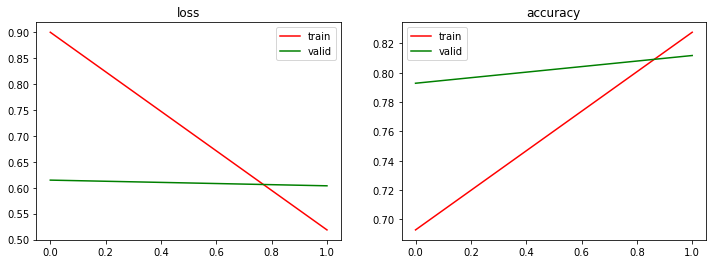

In [76]:
model = Model()
optim = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

train(
    model=model,
    optim=optim,
    criterion=criterion,
    train_dataloader=train_loader,
    valid_dataloader=valid_loader,
    n_epochs=2,
    device=device,
)